import dependancies used for data preprocessing phase

In [13]:
#import kaggle
import os
import pandas as pd
#import glob
import spacy
import gc
from tqdm import tqdm
tqdm.pandas()

download pmc-articles dataset of medical articles' abstracts from kaggle

In [3]:
# if not os.path.exists(r"C:\Users\seifa\Desktop\Python\Beginner_natural_language_processing\medical_articles_abstracts"):
#     os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')
#     kaggle.api.dataset_download_files('cvltmao/pmc-articles', path='medical_articles_abstracts', unzip=True)
#     print("Dataset downloaded and unzipped to: Medical Articles Abstracts/")

import a scispacy model 

In [4]:
nlp = spacy.load("en_core_sci_sm", disable=["tagger", "parser", "lemmatizer", "ner", "attribute_ruler"])
nlp.add_pipe("sentencizer")

nlp.analyze_pipes()

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'sentencizer': {'assigns': ['token.is_sent_start', 'doc.sents'],
   'requires': [],
   'scores': ['sents_f', 'sents_p', 'sents_r'],
   'retokenizes': False}},
 'problems': {'tok2vec': [], 'sentencizer': []},
 'attrs': {'token.is_sent_start': {'assigns': ['sentencizer'], 'requires': []},
  'doc.sents': {'assigns': ['sentencizer'], 'requires': []},
  'doc.tensor': {'assigns': ['tok2vec'], 'requires': []}}}

This function preprocesses the dataset by removing duplicates and missing abstracts, cleaning whitespace and special characters in the `abstract` column, and returning the cleaned DataFrame.


In [5]:
def data_cleaning(df):
    df.duplicated().sum()
    print(f"Number of duplicated rows: {df.duplicated().sum()}")
    df.drop_duplicates(inplace=True)

    df = df.dropna(subset=['abstract']).reset_index(drop=True)
    df['abstract'] = df['abstract'].str.replace(u'\xa0', ' ', regex=False)
    df['abstract'] = df['abstract'].str.replace(r'\s+', ' ', regex=True)
    df['abstract'] = df['abstract'].str.replace(u'\xad', '', regex=False)

    return df

pass the df to the model

In [6]:
def tokenize(df):
    print("     Tokenizing abstracts...")
    docs = []
    for doc in tqdm(nlp.pipe(df['abstract'], batch_size=8, n_process=1), total=len(df['abstract'])):
        docs.append(doc)
    
    return docs
    

This function splits a processed SpaCy `Doc` object into smaller chunks of sentences. Each chunk contains up to `max_tokens` words. Sentences longer than `max_tokens` are stored as individual chunks. The function returns a list of sentence chunks suitable for embedding.

In [7]:
# Extract sentences
def chunk_doc_by_sentences(doc, max_tokens=120):
    sentences = [sent.text.strip() for sent in doc.sents]
    chunks, current_chunk, current_tokens = [], [], 0
    for sent in sentences:
        sent_tokens = len(sent.split())

        if sent_tokens > max_tokens:
            if current_chunk:
                chunks.append(" ".join(current_chunk))
                current_chunk, current_tokens = [], 0
            # append a long sentence as its own chunk
            chunks.append(sent)
            continue

        if current_tokens + sent_tokens > max_tokens:
            if current_chunk:
                chunks.append(" ".join(current_chunk))
            current_chunk = [sent]
            current_tokens = sent_tokens
        else:
            current_chunk.append(sent)
            current_tokens += sent_tokens

    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

This script iterates over raw CSV files containing medical abstracts, cleans the data using `data_cleaning`, tokenizes each abstract with SpaCy, and chunks the text into sentence segments using `chunk_doc_by_sentences`. The resulting `chunks` column replaces the original `abstract` column, and the processed DataFrame is saved to a separate directory for chunked outputs. Memory is cleared after processing each file.








In [ ]:
folder_path = "C:\\Users\\seifa\\Desktop\\Python\\Beginner_natural_language_processing\\medical_articles_abstracts\\raw"
folder_path_2 = "C:\\Users\\seifa\\Desktop\\Python\\Beginner_natural_language_processing\\medical_articles_abstracts\\chunked"


for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        print(f"Processing file: {file}")
        df = pd.read_csv(os.path.join(folder_path, file))
        df = data_cleaning(df)

        docs = tokenize(df)
        
        print("     Chunking document into sentences...")
        df['chunks'] = [chunk_doc_by_sentences(doc) for doc in tqdm(docs, total=len(docs))]
        df.drop(columns=['abstract'], inplace=True)

        df.to_csv(os.path.join(folder_path_2, f"chunked_{file}"), index=False)
        print(f"Processed and saved: chunked_{file}")

        del docs
        del df
        gc.collect()

Processing file: o_z_1.csv
Number of duplicated rows: 0
     Tokenizing abstracts...


100%|██████████| 174907/174907 [20:59<00:00, 138.84it/s]


     Chunking document into sentences...


100%|██████████| 174907/174907 [00:39<00:00, 4426.12it/s] 


Processed and saved: chunked_o_z_1.csv
Processing file: o_z_2.csv
Number of duplicated rows: 0
     Tokenizing abstracts...


100%|██████████| 173880/173880 [26:07<00:00, 110.94it/s]


     Chunking document into sentences...


100%|██████████| 173880/173880 [00:56<00:00, 3060.42it/s]


Processed and saved: chunked_o_z_2.csv
Processing file: o_z_3.csv
Number of duplicated rows: 0
     Tokenizing abstracts...


100%|██████████| 175096/175096 [26:53<00:00, 108.50it/s]


     Chunking document into sentences...


100%|██████████| 175096/175096 [01:01<00:00, 2847.24it/s]


Processed and saved: chunked_o_z_3.csv


we can merge all dfs to a global one

In [ ]:
# files = glob.glob("Beginner_natural_language_processing\medical_articles_abstracts\chunked/*.csv")
# df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
# df.to_csv("PMCabstract_full.csv", index=False)

import dependancies used for embedding and vector database storage

In [11]:
import pandas as pd
import numpy as np
import ast
from sentence_transformers import SentenceTransformer
import faiss

Load the embedding model

In [ ]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

The `embed_chunks` function converts the string representation of chunk lists back to Python lists, flattens all sentences into a single list for the current file (`file_chunks`), and appends them to a global `all_chunks` list to track all chunks across files. It then generates vector embeddings for these sentences using the pre-loaded `embed_model`, returning the embeddings for the current file.









In [17]:
def embed_chunks(df, all_chunks):
    df['chunks'] = df['chunks'].apply(ast.literal_eval)     # convert string representation of list back to list

    
    file_chunks = []
    for chunk in df['chunks']:
        for sent in chunk:
            file_chunks.append(sent)
            all_chunks.append(sent)


    embeddings = embed_model.encode(file_chunks, convert_to_numpy=True, batch_size=64, show_progress_bar=True)

    return embeddings

This cell initializes a FAISS index using an inner product metric (for cosine similarity after normalization) with an embedding dimension of 384. It iterates over each CSV file,  normalizes the embeddings, and adds them to the main FAISS index. After processing all files, the combined index is saved locally as `combined_faiss_index_final.faiss`. The `all_chunks` list keeps track of all text chunks across files for later retrieval.




In [18]:
d = 384  # embedding dimension(all-MiniLM-L6-v2)
index = faiss.IndexFlatIP(d)  # inner product = cosine similarity after normalization
all_chunks = []

for file in os.listdir("C:\\Users\\seifa\\Desktop\\Python\\Beginner_natural_language_processing\\medical_articles_abstracts"):
    if file.endswith('.csv'):

        print(f"Processing file: {file}")
        df = pd.read_csv(os.path.join("C:\\Users\\seifa\\Desktop\\Python\\Beginner_natural_language_processing\\medical_articles_abstracts", file))

        # 2. Embed all chunks
        print("     Embedding chunks...")
        embeddings = embed_chunks(df.iloc[:1000, :], all_chunks)
        del df
        gc.collect()

        # 3. Normalize embeddings if using cosine similarity
        print("     Normalizing embeddings...")
        faiss.normalize_L2(embeddings)

        # 4. Create FAISS index
        print("     Adding embeddings to main index...")
        index.add(embeddings)
        print(f"     updated total nb of vectors in index: {index.ntotal}")

        del embeddings
        gc.collect()

faiss.write_index(index, "combined_faiss_index_final.faiss")
print("Final FAISS index saved successfully.")

Processing file: chunked_a_b.csv
     Embedding chunks...


C:\Users\seifa\AppData\Local\Temp\ipykernel_14280\132584837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunks'] = df['chunks'].apply(ast.literal_eval)     # convert string representation of list back to list


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

     Normalizing embeddings...
     Adding embeddings to main index...
     updated total nb of vectors in index: 2617
Processing file: chunked_c_h.csv
     Embedding chunks...


C:\Users\seifa\AppData\Local\Temp\ipykernel_14280\132584837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunks'] = df['chunks'].apply(ast.literal_eval)     # convert string representation of list back to list


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

     Normalizing embeddings...
     Adding embeddings to main index...
     updated total nb of vectors in index: 4979
Processing file: chunked_i_n.csv
     Embedding chunks...


C:\Users\seifa\AppData\Local\Temp\ipykernel_14280\132584837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunks'] = df['chunks'].apply(ast.literal_eval)     # convert string representation of list back to list


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

     Normalizing embeddings...
     Adding embeddings to main index...
     updated total nb of vectors in index: 7542
Processing file: chunked_o_z_1.csv
     Embedding chunks...


C:\Users\seifa\AppData\Local\Temp\ipykernel_14280\132584837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunks'] = df['chunks'].apply(ast.literal_eval)     # convert string representation of list back to list


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

     Normalizing embeddings...
     Adding embeddings to main index...
     updated total nb of vectors in index: 9665
Processing file: chunked_o_z_2.csv
     Embedding chunks...


C:\Users\seifa\AppData\Local\Temp\ipykernel_14280\132584837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunks'] = df['chunks'].apply(ast.literal_eval)     # convert string representation of list back to list


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

     Normalizing embeddings...
     Adding embeddings to main index...
     updated total nb of vectors in index: 12092
Processing file: chunked_o_z_3.csv
     Embedding chunks...


C:\Users\seifa\AppData\Local\Temp\ipykernel_14280\132584837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunks'] = df['chunks'].apply(ast.literal_eval)     # convert string representation of list back to list


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

     Normalizing embeddings...
     Adding embeddings to main index...
     updated total nb of vectors in index: 14692
Final FAISS index saved successfully.


This cell demonstrates how to query the FAISS index. The query string is first embedded using the same embedding model, normalized, and then used to retrieve the top 5 most similar chunks from the index along with their similarity scores (`distances`) and indices in the `all_chunks` list.


In [ ]:
# 5. Query example
query = "What were the health impacts of micronutrient deficiencies in South African children?"
query_emb = embed_model.encode([query], convert_to_numpy=True)
faiss.normalize_L2(query_emb)
k = 5  # top-k chunks
distances, indices = index.search(query_emb, k)

In [80]:
# 6. Retrieve top-k chunk texts
top_chunks = [all_chunks[i] for i in indices[0]]
top_chunks

['Globally, there is evidence that three micronutrients deficiencies are of public health concern among children. They are vitamin A, iodine and iron deficiencies. Communities particularly affected are those in situations where poverty, unemployment, civil unrest, war and exploitation remain endemic. Malnutrition is an impediment to productivity, economic growth and poverty eradication. It is estimated that 32% of the global burden would be removed by eliminating malnutrition, including micronutrients deficiencies. The study was carried out in NkowaNkowa township of Mopani District, Limpopo Province, South Africa. The main objective was to determine the women’s knowledge on food fortification. The study design was descriptive. The snowballing method was used to identify women of child-bearing age.',
 'The Constitution of South Africa stipulates that all children have the right to basic nutrition; however, a great number of South African children are underweight for age. It is important

This cell visualizes the structure of the FAISS index using t-SNE. 

- A sample of 1000 vectors from the index is projected into 2D for visualization.
- The query embedding and its top-k retrieved vectors are highlighted.
- Light gray points represent the sampled index vectors.
- The red point represents the query.
- Blue points represent the top-k most similar chunks retrieved by the query.

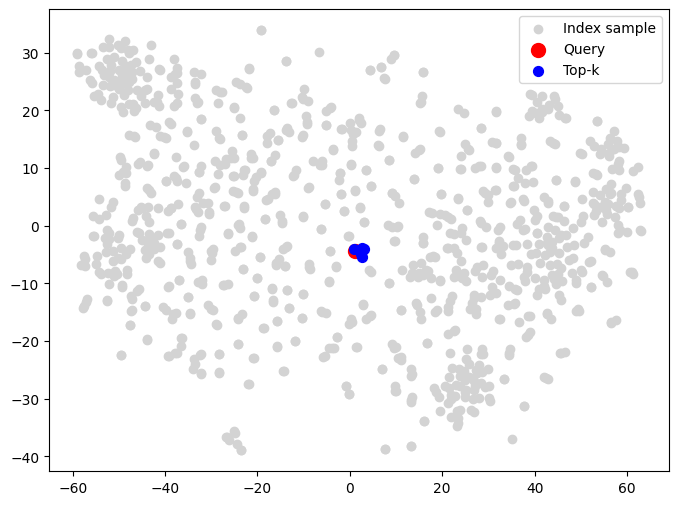

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

num_samples = min(1000, index.ntotal)
sample_vectors = index.reconstruct_n(0, num_samples)

# prepare vectors for t-SNE
sample_vectors = index.reconstruct_n(0, min(1000, index.ntotal))  # take first 1000
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj = tsne.fit_transform(sample_vectors)


topk_vectors = np.vstack([index.reconstruct(int(idx)) for idx in indices[0]])
query_and_topk = np.vstack([query_emb, topk_vectors])
all_vectors = np.vstack([sample_vectors, query_and_topk])

# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj = tsne.fit_transform(all_vectors)

# plot
plt.figure(figsize=(8,6))
plt.scatter(proj[:num_samples,0], proj[:num_samples,1], c='lightgray', label='Index sample')
plt.scatter(proj[num_samples,0], proj[num_samples,1], c='red', label='Query', s=100)
plt.scatter(proj[num_samples+1:,0], proj[num_samples+1:,1], c='blue', label='Top-k', s=50)
plt.legend()
plt.show()


This cell loads the BioMistral-7B model with 4-bit quantization to reduce VRAM usage.

- `BitsAndBytesConfig` is used for 4-bit quantization.
- `AutoTokenizer` loads the corresponding tokenizer.
- `AutoModelForCausalLM` loads the model with GPU/CPU offloading.
- This setup is intended to enable running a large LLM on limited hardware (e.g., 16GB RAM, 6GB VRAM).

In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline

model_name = "BioMistral/BioMistral-7B"

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype="float16" 
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
llm = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map={"": 0},  # use "auto" or custom device_map
    load_in_4bit=True,
    llm_int8_enable_fp32_cpu_offload=True  # allow offloading to CPU
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



This cell sets up a `pipeline` for text generation using the loaded LLM and executes a sample query.

- The query asks about health impacts of micronutrient deficiencies in South African children.
- `max_length` limits the response length.
- `do_sample=True` and `temperature=0.2` introduce controlled randomness in the generation.
- The generated text is printed directly.

In [21]:
qa_pipeline = pipeline(
    "text-generation",
    model=llm,
    tokenizer=tokenizer
)

query = "What were the health impacts of micronutrient deficiencies in South African children?"
response = qa_pipeline(query, max_length=300, do_sample=True, temperature=0.2)
print(response[0]['generated_text'])


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What were the health impacts of micronutrient deficiencies in South African children?


as you can see, the llm without the rag pipeline doesn't output any response.
next cell integrates rag and adds more context to the query prompt.

In [25]:
def generate_answer(query, index, texts, embedder, top_k=5):
    # Embed query
    query_emb = embedder.encode([query])

    # Search FAISS
    distances, indices = index.search(query_emb, top_k)
    retrieved_chunks = [texts[i] for i in indices[0]]

    # Build context for LLM
    context = "\n".join(retrieved_chunks)
    prompt = f"Answer the question based on the context below.\n\nContext:\n{context}\n\nQuestion: {query}\nAnswer:"

    # Generate
    response = qa_pipeline(prompt, max_length=400, do_sample=False)
    return response[0]['generated_text']

response = generate_answer(query, index, all_chunks, embed_model)
print(response)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=400) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Answer the question based on the context below.

Context:
Globally, there is evidence that three micronutrients deficiencies are of public health concern among children. They are vitamin A, iodine and iron deficiencies. Communities particularly affected are those in situations where poverty, unemployment, civil unrest, war and exploitation remain endemic. Malnutrition is an impediment to productivity, economic growth and poverty eradication. It is estimated that 32% of the global burden would be removed by eliminating malnutrition, including micronutrients deficiencies. The study was carried out in NkowaNkowa township of Mopani District, Limpopo Province, South Africa. The main objective was to determine the women’s knowledge on food fortification. The study design was descriptive. The snowballing method was used to identify women of child-bearing age.
The Constitution of South Africa stipulates that all children have the right to basic nutrition; however, a great number of South Afric